This notebook provides examples to go along with the [textbook](http://manipulation.csail.mit.edu/force.html).  I recommend having both windows open, side-by-side!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Box,
    ConstantVectorSource,
    ContactVisualizer,
    ContactVisualizerParams,
    DiagramBuilder,
    DiscreteContactApproximation,
    FixedOffsetFrame,
    InverseDynamicsController,
    JointSliders,
    LeafSystem,
    LogVectorOutput,
    MathematicalProgram,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    Multiplexer,
    OsqpSolver,
    Parser,
    PiecewisePolynomial,
    PlanarJoint,
    PrismaticJoint,
    RevoluteJoint,
    RigidTransform,
    RotationMatrix,
    SceneGraph,
    Simulator,
    SpatialInertia,
    Sphere,
    StartMeshcat,
    TrajectorySource,
    UnitInertia,
)

from manipulation import running_as_notebook
from manipulation.meshcat_utils import MeshcatSliders
from manipulation.scenarios import AddShape, SetColor, SetTransparency
from manipulation.utils import ConfigureParser

In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://09bc463a-17e1-4486-8764-1ca9d9b209cb.deepnoteproject.com/7000/
Installing NginX server for MeshCat on Deepnote...


In [ ]:
def AddPlanarBinAndCracker(plant):
    parser = Parser(plant)
    ConfigureParser(parser)
    bin = parser.AddModelsFromUrl("package://manipulation/planar_bin.sdf")[0]
    plant.WeldFrames(
        plant.world_frame(),
        plant.GetFrameByName("bin_base", bin),
        RigidTransform(RotationMatrix.MakeZRotation(np.pi / 2.0), [0, 0, -0.015]),
    )

    planar_joint_frame = plant.AddFrame(
        FixedOffsetFrame(
            "planar_joint_frame",
            plant.world_frame(),
            RigidTransform(RotationMatrix.MakeXRotation(np.pi / 2)),
        )
    )
    box = parser.AddModelsFromUrl(
        "package://drake/manipulation/models/ycb/sdf/003_cracker_box.sdf"
    )[0]
    box_frame = plant.AddFrame(
        FixedOffsetFrame(
            "box_frame",
            plant.GetFrameByName("base_link_cracker", box),
            RigidTransform(RotationMatrix.MakeXRotation(np.pi / 2)),
        )
    )
    box_joint = plant.AddJoint(PlanarJoint("box_joint", planar_joint_frame, box_frame))
    box_joint.set_default_translation([0, 0.033400])
    return box


def AddPlanarBinAndSimpleBox(
    plant, mass=1.0, mu=1.0, width=0.2, depth=0.05, height=0.3
):
    parser = Parser(plant)
    ConfigureParser(parser)
    bin = parser.AddModelsFromUrl("package://manipulation/planar_bin.sdf")[0]
    plant.WeldFrames(
        plant.world_frame(),
        plant.GetFrameByName("bin_base", bin),
        RigidTransform(RotationMatrix.MakeZRotation(np.pi / 2.0), [0, 0, -0.015]),
    )

    planar_joint_frame = plant.AddFrame(
        FixedOffsetFrame(
            "planar_joint_frame",
            plant.world_frame(),
            RigidTransform(RotationMatrix.MakeXRotation(np.pi / 2)),
        )
    )

    # TODO(russt): make this a *random* box?
    # TODO(russt): move random box to a shared py file.
    box_instance = AddShape(plant, Box(width, depth, height), "box", mass, mu)
    box_joint = plant.AddJoint(
        PlanarJoint(
            "box_joint",
            planar_joint_frame,
            plant.GetFrameByName("box", box_instance),
        )
    )
    box_joint.set_default_translation([0, height / 2.0])
    return box_instance


def AddPlanarGripper(plant):
    parser = Parser(plant)
    ConfigureParser(parser)
    gripper = parser.AddModelsFromUrl(
        "package://manipulation/schunk_wsg_50_welded_fingers.sdf"
    )[0]

    # Add a planar joint the old fashioned way (so that I can have three actuators):
    gripper_false_body1 = plant.AddRigidBody(
        "false_body1",
        gripper,
        SpatialInertia(0, [0, 0, 0], UnitInertia(0, 0, 0)),
    )
    gripper_false_body2 = plant.AddRigidBody(
        "false_body2",
        gripper,
        SpatialInertia(0, [0, 0, 0], UnitInertia(0, 0, 0)),
    )
    gripper_x = plant.AddJoint(
        PrismaticJoint(
            "gripper_x",
            plant.world_frame(),
            plant.GetFrameByName("false_body1"),
            [1, 0, 0],
            -0.3,
            0.3,
        )
    )
    plant.AddJointActuator("gripper_x", gripper_x)
    gripper_z = plant.AddJoint(
        PrismaticJoint(
            "gripper_z",
            plant.GetFrameByName("false_body1"),
            plant.GetFrameByName("false_body2"),
            [0, 0, 1],
            0.0,
            0.5,
        )
    )
    gripper_z.set_default_translation(0.3)
    plant.AddJointActuator("gripper_z", gripper_z)
    gripper_frame = plant.AddFrame(
        FixedOffsetFrame(
            "gripper_frame",
            plant.GetFrameByName("body", gripper),
            RigidTransform(RotationMatrix.MakeXRotation(np.pi / 2)),
        )
    )
    gripper_theta = plant.AddJoint(
        RevoluteJoint(
            "gripper_theta",
            plant.GetFrameByName("false_body2"),
            gripper_frame,
            [0, -1, 0],
            -np.pi,
            np.pi,
        )
    )
    plant.AddJointActuator("gripper_theta", gripper_theta)

    return gripper


def MakePlanarGripperOnlyPlant():
    plant = MultibodyPlant(time_step=0.005)
    AddPlanarGripper(plant)
    plant.Finalize()
    return plant


def AddPointFinger(plant):
    finger = AddShape(plant, Sphere(0.01), "finger", color=[0.9, 0.5, 0.5, 1.0])
    false_body1 = plant.AddRigidBody(
        "false_body1",
        finger,
        SpatialInertia(0, [0, 0, 0], UnitInertia(0, 0, 0)),
    )
    finger_x = plant.AddJoint(
        PrismaticJoint(
            "finger_x",
            plant.world_frame(),
            plant.GetFrameByName("false_body1"),
            [1, 0, 0],
            -0.3,
            0.3,
        )
    )
    plant.AddJointActuator("finger_x", finger_x)
    finger_z = plant.AddJoint(
        PrismaticJoint(
            "finger_z",
            plant.GetFrameByName("false_body1"),
            plant.GetFrameByName("finger"),
            [0, 0, 1],
            0.0,
            0.5,
        )
    )
    finger_z.set_default_translation(0.25)
    plant.AddJointActuator("finger_z", finger_z)

    return finger


def MakeFingerOnlyPlant():
    plant = MultibodyPlant(time_step=0.005)
    AddPointFinger(plant)
    plant.Finalize()
    return plant


class PointFingerForceControl(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant

        self.DeclareVectorInputPort("desired_contact_force", 2)
        self.DeclareVectorOutputPort("finger_actuation", 2, self.CalcOutput)

    def CalcOutput(self, context, output):
        finger_mass = 1
        g = self._plant.gravity_field().gravity_vector()[[0, 2]]

        desired_force = self.get_input_port(0).Eval(context)
        output.SetFromVector(-finger_mass * g - desired_force)

# Commanding a constant force

INFO:drake:PackageMap: Downloading https://github.com/RobotLocomotion/models/archive/fe5326c5ffc36fda12c58883d22d29dc86009d65.tar.gz


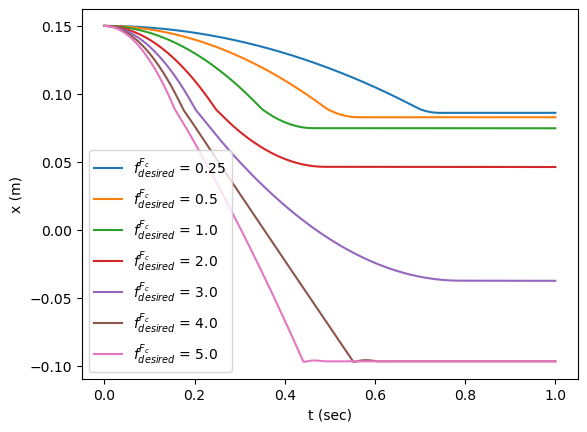

In [ ]:
def force_control_point_finger(
    desired_horizontal_forces=[4.0], duration=1.0, draw=False
):
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    AddPlanarBinAndCracker(plant)
    finger = AddPointFinger(plant)
    plant.GetJointByName("finger_x").set_default_translation(0.15)
    plant.GetJointByName("finger_z").set_default_translation(0.05)
    plant.Finalize()

    if draw:
        MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
        #        vis.vis['drake']['4'].delete()  # Only flush the gripper geometry.
        #    vis.set_planar_viewpoint(xmin=-.5, xmax=.5, ymin=-0.1, ymax=0.6)
        ContactVisualizer.AddToBuilder(
            builder, plant, meshcat, ContactVisualizerParams(radius=0.005)
        )
    controller = builder.AddSystem(PointFingerForceControl(plant))
    builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())
    builder.ExportInput(controller.get_input_port(), "desired_contact_force")

    logger = LogVectorOutput(plant.get_state_output_port(finger), builder)

    diagram = builder.Build()

    plt.figure()
    lines = []
    for f in desired_horizontal_forces:
        simulator = Simulator(diagram)
        context = simulator.get_mutable_context()
        diagram.get_input_port().FixValue(context, [f, 0])

        simulator.AdvanceTo(duration)
        log = logger.FindMutableLog(context)
        t = log.sample_times()
        x = log.data()
        lines.append(plt.plot(t, x[0, :])[0])

    plt.legend(
        lines,
        [("$f^{F_c}_{desired}$ = " + str(f)) for f in desired_horizontal_forces],
    )
    plt.xlabel("t (sec)")
    plt.ylabel("x (m)")


force_control_point_finger([0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0])

#  A force-based flip-up strategy

In [ ]:
def force_control_point_finger(teleop=True):
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.005)
    plant.set_discrete_contact_approximation(DiscreteContactApproximation.kSap)
    box = AddPlanarBinAndCracker(plant)
    finger = AddPointFinger(plant)
    plant.GetJointByName("finger_x").set_default_translation(0.15)
    plant.GetJointByName("finger_z").set_default_translation(0.025)
    plant.Finalize()

    vis = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # vis.vis['drake']['4'].delete()  # Only flush the gripper geometry.
    # vis.set_planar_viewpoint(xmin=-.5, xmax=.5, ymin=-0.1, ymax=0.6)
    contact_vis = ContactVisualizer.AddToBuilder(
        builder,
        plant,
        meshcat,
        ContactVisualizerParams(radius=0.005, newtons_per_meter=40.0),
    )

    class RotateBoxOnTopCorner(LeafSystem):
        def __init__(self, plant):
            LeafSystem.__init__(self)
            self._plant = plant

            # One state variable for the integral error.
            self.DeclareContinuousState(1)

            self.DeclareVectorInputPort("desired_box_angle", 1)
            self.DeclareVectorInputPort("box_state", 6)
            self.DeclareVectorInputPort("finger_state", 4)
            self.DeclareVectorOutputPort("finger_force", 2, self.CalcOutput)
            self.solver = OsqpSolver()

        def DoCalcTimeDerivatives(self, context, derivatives):
            # Compute integral of the angle error.
            theta_desired = self.get_input_port(0).Eval(context)[0]
            theta = self.get_input_port(1).Eval(context)[2]
            derivatives.get_mutable_vector().SetFromVector([theta_desired - theta])

        def CalcOutput(self, context, output):
            # TODO(russt): Clean this up to match the cleaned up derivation in
            # the text.
            box_mass = 0.411  # Let's revisit whether we need this!
            mu_A = 1.0
            mu_C = 1.0
            w = 0.2  # Approximate box width
            g = -self._plant.gravity_field().gravity_vector()[2]

            theta_desired = self.get_input_port(0).Eval(context)[0]
            box_state = self.get_input_port(1).Eval(context)
            theta = box_state[2]
            theta_dot = box_state[5]

            R_WC = np.array(
                [
                    [-np.sin(theta), -np.cos(theta)],
                    [np.cos(theta), -np.sin(theta)],
                ]
            )
            R_CW = R_WC.T
            self.get_input_port(2).Eval(context)

            prog = MathematicalProgram()
            f_C_W = prog.NewContinuousVariables(2, "f_C_W")  # force from finger to box
            f_C_C = np.matmul(R_CW, f_C_W)

            # PID control on f_CC[1]
            kp = 20.0
            ki = 0.5
            kd = 2.0 * np.sqrt(kp)  # should really be kp*I on inside
            integral_error = context.get_continuous_state_vector().GetAtIndex(0)
            pid = kp * (theta_desired - theta) + ki * integral_error - kd * theta_dot
            prog.AddQuadraticCost((w * f_C_C[0] - pid) ** 2, True)

            prog.AddConstraint(f_C_W[0] <= mu_A * (box_mass * g - f_C_W[1]))
            prog.AddConstraint(-f_C_W[0] <= mu_A * (box_mass * g - f_C_W[1]))
            prog.AddConstraint(f_C_C[1] >= 0.1)  # To ensure I make and stay in contact.
            prog.AddConstraint(f_C_C[0] <= mu_C * f_C_C[1])
            prog.AddConstraint(-f_C_C[0] <= mu_C * f_C_C[1])

            result = self.solver.Solve(prog)

            if not result.is_success():
                print(result.GetInfeasibleConstraintNames(prog))
                output.SetFromVector([0, 0])
                return

            f_C_W = result.GetSolution(f_C_W)
            output.SetFromVector(-f_C_W)

    controller = builder.AddSystem(PointFingerForceControl(plant))
    builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())

    rotate_box = builder.AddSystem(RotateBoxOnTopCorner(plant))
    builder.Connect(rotate_box.get_output_port(), controller.get_input_port())
    builder.Connect(plant.get_state_output_port(box), rotate_box.get_input_port(1))
    builder.Connect(plant.get_state_output_port(finger), rotate_box.get_input_port(2))

    if teleop:
        meshcat.AddSlider(
            "desired box angle",
            value=0,
            min=0,
            max=np.pi / 2,
            step=0.05,
            increment_keycode="ArrowLeft",
            decrement_keycode="ArrowRight",
        )
        teleop = builder.AddSystem(MeshcatSliders(meshcat, [["desired box angle"]]))
        builder.Connect(teleop.get_output_port(), rotate_box.get_input_port(0))
    else:
        theta_trajectory = PiecewisePolynomial.FirstOrderHold(
            [0, 2, 20], [[0, 0, np.pi / 2.0]]
        )
        trajectory_source = builder.AddSystem(TrajectorySource(theta_trajectory))
        builder.Connect(
            trajectory_source.get_output_port(), rotate_box.get_input_port(0)
        )

    diagram = builder.Build()
    simulator = Simulator(diagram)

    if not running_as_notebook:
        simulator.AdvanceTo(0.01)
    elif teleop:
        meshcat.AddButton("Stop Simulation", "Escape")
        while meshcat.GetButtonClicks("Stop Simulation") < 1:
            simulator.AdvanceTo(simulator.get_context().get_time() + 2.0)
        meshcat.DeleteButton("Stop Simulation")
        meshcat.DeleteAddedControls()
    else:
        simulator.set_target_realtime_rate(0.5)  # slow motion!
        vis.StartRecording()
        simulator.AdvanceTo(theta_trajectory.end_time())
        vis.StopRecording()
        contact_vis.Delete()  # TODO: make my recording include the contact forces!
        vis.PublishRecording()


force_control_point_finger(teleop=True)

# Teleop with Stiffness Control


In [ ]:
def stiffness_box_flipup(point_finger=True, teleop=False):
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    # plant.set_discrete_contact_approximation(DiscreteContactApproximation.kLagged)

    AddPlanarBinAndSimpleBox(plant)
    # AddPlanarBinAndCracker(plant)
    SetTransparency(scene_graph, alpha=0.5, source_id=plant.get_source_id())

    gripper = AddPointFinger(plant) if point_finger else AddPlanarGripper(plant)
    plant.Finalize()

    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    meshcat.Set2dRenderMode(xmin=-0.5, xmax=0.5, ymin=-0.1, ymax=0.6)
    ContactVisualizer.AddToBuilder(
        builder,
        plant,
        meshcat,
        ContactVisualizerParams(radius=0.005, newtons_per_meter=40.0),
    )

    # Use the controller plant to visualize the set point geometry.
    controller_scene_graph = builder.AddSystem(SceneGraph())
    controller_plant = MultibodyPlant(time_step=0.005)
    controller_plant.RegisterAsSourceForSceneGraph(controller_scene_graph)
    AddPointFinger(controller_plant) if point_finger else AddPlanarGripper(
        controller_plant
    )
    controller_plant.Finalize()
    SetColor(
        controller_scene_graph,
        color=[1.0, 165.0 / 255, 0.0, 1.0],
        source_id=controller_plant.get_source_id(),
    )
    controller_vis = MeshcatVisualizer.AddToBuilder(
        builder,
        controller_scene_graph,
        meshcat,
        MeshcatVisualizerParams(prefix="controller"),
    )
    controller_vis.set_name("controller meshcat")

    # TODO(russt): Implement the proper JointStiffnessController in drake and
    # use it here. (For a point finger with unit mass, the
    # InverseDynamicsController is identical)
    N = controller_plant.num_positions()
    kp = [100] * N
    ki = [1] * N
    kd = [2 * np.sqrt(kp[0])] * N
    controller = builder.AddSystem(
        InverseDynamicsController(controller_plant, kp, ki, kd, False)
    )
    builder.Connect(
        plant.get_state_output_port(gripper),
        controller.get_input_port_estimated_state(),
    )

    positions_to_state = builder.AddSystem(Multiplexer([N, N]))
    zeros = builder.AddSystem(ConstantVectorSource([0] * N))
    builder.Connect(zeros.get_output_port(0), positions_to_state.get_input_port(1))
    builder.Connect(
        positions_to_state.get_output_port(),
        controller.get_input_port_desired_state(),
    )
    positions_to_poses = builder.AddSystem(
        MultibodyPositionToGeometryPose(controller_plant)
    )
    builder.Connect(
        positions_to_poses.get_output_port(),
        controller_scene_graph.get_source_pose_port(controller_plant.get_source_id()),
    )
    builder.Connect(
        controller.get_output_port_control(), plant.get_actuation_input_port()
    )

    if teleop:
        position_sliders = builder.AddSystem(
            JointSliders(
                meshcat,
                controller_plant,
                step=0.01,
                decrement_keycodes=["ArrowLeft", "ArrowDown"],
                increment_keycodes=["ArrowRight", "ArrowUp"],
            )
        )
        builder.Connect(
            position_sliders.get_output_port(),
            positions_to_state.get_input_port(0),
        )
        builder.Connect(
            position_sliders.get_output_port(),
            positions_to_poses.get_input_port(),
        )
    else:
        traj = PiecewisePolynomial.FirstOrderHold(
            [0, 10.0, 20.0],
            np.array([[0.15, 0.025], [-0.25, 0.025], [-0.25, 0.125]]).T,
        )
        traj_system = builder.AddSystem(TrajectorySource(traj))
        builder.Connect(
            traj_system.get_output_port(), positions_to_state.get_input_port(0)
        )
        builder.Connect(
            traj_system.get_output_port(), positions_to_poses.get_input_port()
        )

    diagram = builder.Build()
    simulator = Simulator(diagram)

    if not running_as_notebook:
        simulator.AdvanceTo(0.01)
    elif teleop:
        simulator.set_target_realtime_rate(1.0)
        meshcat.AddButton("Stop Simulation", "Escape")
        while meshcat.GetButtonClicks("Stop Simulation") < 1:
            simulator.AdvanceTo(simulator.get_context().get_time() + 2.0)
        meshcat.DeleteButton("Stop Simulation")
        meshcat.DeleteAddedControls()
    else:
        simulator.set_target_realtime_rate(1.0)
        simulator.AdvanceTo(traj.end_time() + 1.0)

# A stiffness-control-based flip-up strategy

In [ ]:
stiffness_box_flipup(point_finger=True, teleop=True)

In [ ]:
stiffness_box_flipup(point_finger=True, teleop=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=09bc463a-17e1-4486-8764-1ca9d9b209cb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>